In [1]:
import numpy as np           # 匯入 NumPy 庫，用於數值計算與矩陣操作
import matplotlib.pyplot as plt  # 匯入 Matplotlib 的繪圖模組，用於資料視覺化
import scipy.io as sio      # 匯入 SciPy 的 IO 模組，專門用來讀取 MATLAB 的 .mat 檔案

# 從指定路徑載入 MATLAB 格式的數據檔案
# 這裡的回傳值 dataset 是一個字典 (dict) 格式
dataset = sio.loadmat("/content/drive/MyDrive/Colab Notebooks/Machine-Learning/Data/water.mat")

# 從字典中提取特徵變數 (Features)
x_train = dataset["X"]      # 訓練集特徵 (通常是水庫水位變化)
x_val = dataset["Xval"]     # 驗證集特徵 (用於調整超參數)
x_test = dataset["Xtest"]    # 測試集特徵 (用於評估最終模型性能)

# 提取目標變數 (Target/Label)，並使用 .squeeze() 將二維陣列壓縮成一維
# 例如：將形狀為 (12, 1) 的矩陣轉換為 (12,) 的向量，方便後續計算
y_train = dataset["y"].squeeze()     # 訓練集標籤 (通常是流出的水量)
y_val = dataset["yval"].squeeze()    # 驗證集標籤
y_test = dataset["ytest"].squeeze()   # 測試集標籤

# 印出各個資料集的維度 (Shape)，確認資料筆數與特徵數量是否正確
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

# 印出訓練集的前 5 筆資料，觀察數據內容與數值範圍
print(x_train[:5])
print(y_train[:5])

(12, 1) (12,)
(21, 1) (21,)
(21, 1) (21,)
[[-15.93675813]
 [-29.15297922]
 [ 36.18954863]
 [ 37.49218733]
 [-48.05882945]]
[ 2.13431051  1.17325668 34.35910918 36.83795516  2.80896507]


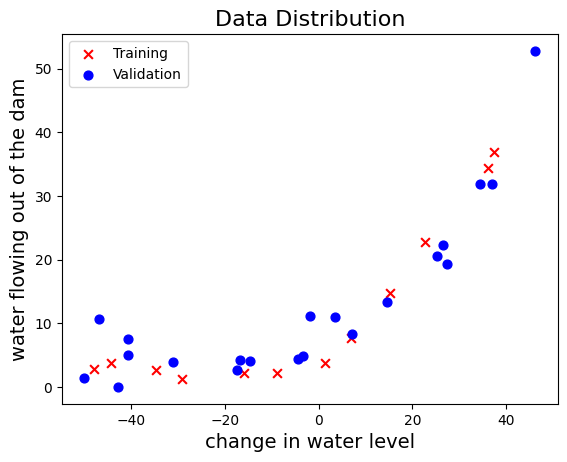

In [2]:
# 繪製訓練集數據：
# x_train (橫軸): 水位變化；y_train (縱軸): 流出水量
# marker="x": 點的形狀用叉叉表示
# s=40: 設定點的大小 (size)
# c='red': 設定顏色為紅色
plt.scatter(x_train, y_train, marker="x", s=40, c='red', label="Training")

# 繪製驗證集數據：
# marker="o": 點的形狀用圓圈表示
# c='blue': 設定顏色為藍色，以便與訓練集區分
plt.scatter(x_val, y_val, marker="o", s=40, c='blue', label="Validation")

# 設定圖表的輔助資訊
plt.xlabel("change in water level", fontsize=14)          # X 軸標籤與字體大小
plt.ylabel("water flowing out of the dam", fontsize=14)   # Y 軸標籤與字體大小
plt.title("Data Distribution", fontsize=16)               # 圖表標題

# 建議加上 plt.legend() 來顯示圖例，區分紅叉與藍圈
plt.legend()

# 顯示最終圖表
plt.show()

In [3]:
def linear_regression_vec(X, y, alpha, num_iters, gamma=0.8, epsilon=1e-8):
    history = []          # 用於記錄每次迭代後的權重 w，方便後續分析

    # 在特徵矩陣 X 的最左側添加一列全為 1 的向量
    # 這是為了處理截距項 (Bias term) b，將模型簡化為 X @ w
    X = np.hstack((np.ones((X.shape[0], 1), dtype=X.dtype), X))

    num_features = X.shape[1]    # 取得特徵總數（包含截距項）

    # 初始化動量 v 和權重 w
    v = np.zeros(num_features)   # 動量項初始化為 0 向量 (修正了原程式 np.zeros_like 的小誤用)
    w = np.zeros(num_features)   # 模型權重初始化為 0

    for n in range(num_iters):
        # 1. 計算假設函數的預測值 f(x) = X * w
        predictions = X @ w

        # 2. 計算預測值與真實值 y 之間的誤差
        errors = predictions - y

        # 3. 計算梯度：(X^T * errors) / m
        # 這是代價函數 J(w) 對 w 的偏導數向量
        gradient = X.transpose() @ errors / len(y)

        # 4. 提前停止準則：如果梯度已經非常小，代表接近極值點，停止迭代，兩個版本，一個取最大值，另一個直接取歐幾里德距離
        if np.linalg.norm(gradient) < epsilon: # 歐幾里德距離
        # if np.max(np.abs(gradient)) < epsilon: # 取最大值
            print("gradient is small enough!")
            print("iterated num is :", n)
            break

        # 5. 更新參數（Momentum 動量法）：
        # v = 過去累積的動量 * 衰減係數(gamma) + 本次梯度 * 學習率(alpha)
        v = gamma * v + alpha * gradient
        w = w - v             # 利用累積的動量來更新權重

        history.append(w.copy())  # 記錄當前權重（建議使用 .copy() 避免參照問題）

    return history  # 回傳優化過程中的所有權重歷史

In [4]:
def compute_loss_history(X, y, w_history):
    loss_history = []  # 初始化一個列表，用來儲存每個階段的損失值

    for w in w_history:
        # 計算誤差 (Errors)：
        # 這裡假設 w[0] 是截距 (Bias)，w[1:] 是特徵的權重
        # X @ w[1:] 是矩陣乘法，算出預測值，加上 w[0] 後再減去真實值 y
        errors = X @ w[1:] + w[0] - y

        # 計算均方誤差 (Mean Squared Error, MSE) 的一半：
        # (errors**2).mean() 計算了誤差平方的平均值
        # 除以 2 是為了在數學求導時能與平方項抵消（線性回歸的標準做法）
        loss = (errors**2).mean() / 2
        loss_history.append(loss)

    return loss_history  # 回傳包含所有迭代階段損失值的列表

In [5]:
# 1. 指定訓練數據：將訓練集的特徵與標籤賦值給 X, y
X, y = x_train, y_train

# 2. 設定超參數 (Hyperparameters)
alpha = 0.001        # 學習率 (Learning Rate)：決定每一步跨出的長度
iterations = 100000  # 最大迭代次數：如果梯度沒提前變小，最多跑十萬次

# 3. 執行訓練：使用動量梯度下降法尋找最優權重 w
# history 儲存了最多 10 萬次迭代中所有的權重路徑
history = linear_regression_vec(X, y, alpha, iterations)

# 4. 取得最終權重：history[-1] 代表最後一次迭代產生的 w (最優解)
w = history[-1]
print("w", history[-1]) # 印出最終的截距 (w0) 與斜率 (w1)

# print(history)

# 5. 計算損失歷史：根據權重演變歷史，計算對應的損失值 (Loss/Cost)
loss_history = compute_loss_history(X, y, history)

# 6. 取樣印出損失值變化：
# loss_history[:-1:len(loss_history)//10]
# 這行利用切片 (Slicing) 每隔 10% 的進度印出一個損失值，用來觀察收斂趨勢
print(loss_history[:-1:len(loss_history)//10])

# 7. 印出最終損失值：確認模型最後收斂到的代價大小
print(loss_history[-1])

gradient is small enough!
iterated num is : 4232
w [13.0879035   0.36777923]
[np.float64(106.08297267143769), np.float64(23.666015886214183), np.float64(22.39338816981072), np.float64(22.374200228481484), np.float64(22.373910923850048), np.float64(22.3739065618829), np.float64(22.37390649611569), np.float64(22.37390649512409), np.float64(22.373906495109143), np.float64(22.373906495108923), np.float64(22.373906495108912)]
22.373906495108915


In [6]:
def plot_history_predict(X, y, w, loss_history, fig_size=(12, 4)):
    # 1. 建立並設定畫布大小
    fig = plt.gcf()
    fig.set_size_inches(fig_size[0], fig_size[1], forward=True)

    # --- 左圖：損失函數下降曲線 ---
    plt.subplot(1, 2, 1) # 建立 1 列 2 欄的圖表，現在畫第 1 個
    plt.plot(loss_history)
    plt.title("Loss History")
    plt.xlabel("Iterations")
    plt.ylabel("Cost")

    # --- 右圖：模型擬合結果 ---
    plt.subplot(1, 2, 2) # 畫第 2 個圖

    # 為了計算預測值，需手動在 X 補上一欄 1 (Bias項)
    X_with_bias = np.hstack((np.ones((X.shape[0], 1), dtype=X.dtype), X))
    x_original = X_with_bias[:, 1] # 取得原始特徵值 (水位變化)

    # 計算模型預測值 (f(x) = X @ w)
    predicts = X_with_bias @ w

    # 畫出預測的數據點 (藍色點)
    plt.scatter(x_original, predicts, alpha=0.5, label='Predictions', marker="o", c="blue")

    # --- 重要步驟：排序資料以繪製平滑曲線 ---
    # 因為原始資料可能是亂序的，直接用 plt.plot 會畫出亂跳的折線
    indices = x_original.argsort()              # 取得從小到大排序的索引
    sorted_x = x_original[indices]              # 排序過的 X
    sorted_predicts = predicts[indices]         # 對應排序過的預測值

    # 畫出紅色的擬合線 (回歸線)
    plt.plot(sorted_x, sorted_predicts, color='red', label='Regression Line')

    # 畫出原始的真實數據點 (通常會呈現為散佈圖)
    plt.scatter(x_original, y, marker="x", c="green", label='Actual Data')

    plt.title("Model Fitting")
    plt.xlabel("Water Level Change")
    plt.ylabel("Water Outflow")
    plt.legend()
    plt.show()

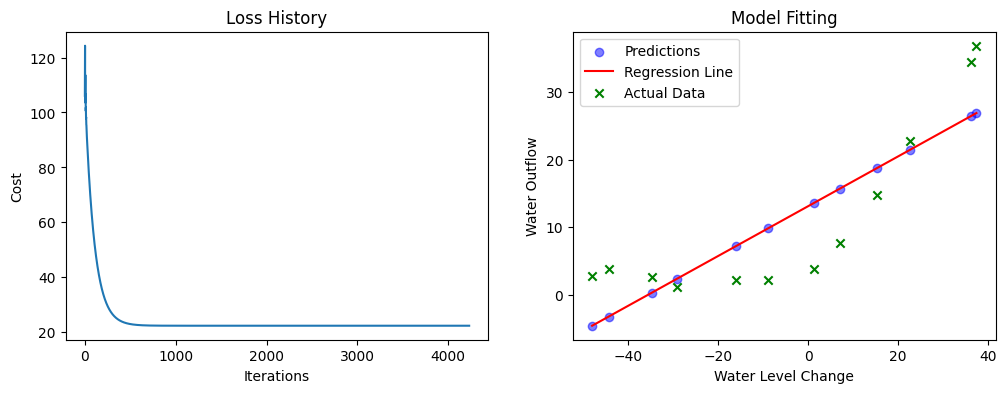

In [7]:
loss_history = compute_loss_history(X,y,history)
plot_history_predict(X,y,w,loss_history)

## 從線性走向非線性

多項式回歸在處理水壩數據時，我們發現水位變化與出水量之間並非簡單的線性關係（直線）。因此，單純的線性假設函數（Linear Hypothesis）並不是最理想的選擇。為了捕捉兩者之間的非線性趨勢，我們可以改用多項式函數。例如，使用「一元三次多項式」來描述水位 $x$ 與出水量 $y$ 之間的關係：

$$f(x) = w_3x^3 + w_2x^2 + w_1x + w_0$$

這個公式可以拆解成向量的內積形式：$$f(x) = (1, x, x^2, x^3) \cdot (w_0, w_1, w_2, w_3)^T$$

特徵構造的奧妙雖然原始數據只有一個特徵 $x$，但我們可以人為地構造出新的特徵 $x^2$ 與 $x^3$。再加上代表截距項（Intercept）的 $1$，原本的一維特徵就被轉換成了一個 4 維的特徵向量 $\pmb x$：

$$\pmb x = (1, x, x^2, x^3)$$如此一來，原本看似複雜的非線性問題，在數學形式上又回到了我們熟悉的線性組合：

$$f(\pmb x; \pmb w) = \pmb x \pmb w$$其中，$\pmb w$ 是模型的權重參數（包含截距與各個次方的係數）。

In [48]:
# 1. 重新賦值：確保使用的是原始的訓練數據，避免因為重複執行儲存格導致 X 被無限疊加
X, y = x_train, y_train

# 2. 特徵構造 (Polynomial Features)：
# 使用 np.hstack (Horizontal Stack) 將原始特徵 X 與它的平方 (X**2)、三次方 (X**3) 水平合併
# 如果原始 X 的形狀是 (12, 1)，執行後的新 X 形狀會變成 (12, 3)
X = np.hstack((X, X**2, X**3))

# 3. 印出結果：檢查矩陣的前幾行，確認特徵是否正確生成
print(X)

[[-1.59367581e+01  2.53980260e+02 -4.04762197e+03]
 [-2.91529792e+01  8.49896197e+02 -2.47770062e+04]
 [ 3.61895486e+01  1.30968343e+03  4.73968522e+04]
 [ 3.74921873e+01  1.40566411e+03  5.27014222e+04]
 [-4.80588295e+01  2.30965109e+03 -1.10999128e+05]
 [-8.94145794e+00  7.99496701e+01 -7.14866612e+02]
 [ 1.53077929e+01  2.34328523e+02  3.58705250e+03]
 [-3.47062658e+01  1.20452489e+03 -4.18045609e+04]
 [ 1.38915437e+00  1.92974986e+00  2.68072045e+00]
 [-4.43837599e+01  1.96991814e+03 -8.74323736e+04]
 [ 7.01350208e+00  4.91892115e+01  3.44988637e+02]
 [ 2.27627489e+01  5.18142738e+02  1.17943531e+04]]


In [34]:
history = linear_regression_vec(X,y,alpha,iterations)
print("w:",history[-1])

/tmp/ipython-input-1724953432.py:16: RuntimeWarning: overflow encountered in matmul
  predictions = X @ w
/tmp/ipython-input-1724953432.py:23: RuntimeWarning: overflow encountered in matmul
  gradient = X.transpose() @ errors / len(y)
/tmp/ipython-input-1724953432.py:23: RuntimeWarning: invalid value encountered in matmul
  gradient = X.transpose() @ errors / len(y)


w: [nan nan nan nan]


In [38]:
# 1. 計算平均值 (Mean)：
# axis=0 代表針對「每一欄」(每個特徵) 分別計算平均
mean = np.mean(X, axis=0)

# 2. 計算標準差 (Standard Deviation)：
# 同樣針對每一欄計算數據的分散程度
stddev = np.std(X, axis=0)

print(mean)
print(stddev)

# 3. 執行標準化 (Z-Score Normalization)：
# 公式：(原始數據 - 平均值) / 標準差
# 這會讓轉換後的數據 std_X 符合：平均值 = 0, 標準差 = 1
std_X = (X - mean) / stddev

# 註解部分補充：
# 如果 X 的第一欄是 1 (截距項)，標準化時應避開第一欄 (因為 1 的標準差是 0，會導致除以 0 錯誤)
# X2[:,1:] = (X2[:,1:] - mean[1:]) / stddev[1:]

print(std_X[:3]) # 印出前三筆觀察轉換結果
print(std_X)

[-5.08542635e+00  8.48904834e+02 -1.28290173e+04]
[2.86887308e+01 7.54346385e+02 4.61380464e+04]
[[-3.78243704e-01 -7.88662325e-01  1.90328720e-01]
 [-8.38920100e-01  1.31420204e-03 -2.58961742e-01]
 [ 1.43871736e+00  6.10831582e-01  1.30534069e+00]]
[[-3.78243704e-01 -7.88662325e-01  1.90328720e-01]
 [-8.38920100e-01  1.31420204e-03 -2.58961742e-01]
 [ 1.43871736e+00  6.10831582e-01  1.30534069e+00]
 [ 1.48412330e+00  7.38068463e-01  1.42031240e+00]
 [-1.49791929e+00  1.93643966e+00 -2.12774745e+00]
 [-1.34409278e-01 -1.01936614e+00  2.62563148e-01]
 [ 7.10844248e-01 -8.14713668e-01  3.55803314e-01]
 [-1.03249041e+00  4.71428060e-01 -6.28018432e-01]
 [ 2.25683763e-01 -1.12279332e+00  2.78115330e-01]
 [-1.36981778e+00  1.48607235e+00 -1.61695958e+00]
 [ 4.21731046e-01 -1.06014377e+00  2.85534542e-01]
 [ 9.70700848e-01 -4.38475085e-01  5.33689054e-01]]


In [49]:
# 1. 設定學習率 (Learning Rate)
# 由於數據已經過標準化 (Standardization)，我們可以使用較大的 alpha (0.3)
# 這會讓模型收斂的速度比之前的 0.001 快非常多
alpha = 0.3

# 2. 執行帶有動量的向量化線性回歸訓練
# 注意：這裡傳入的是 std_X (多項式擴充 + 標準化後的特徵)
history = linear_regression_vec(std_X, y, alpha, iterations)

# 3. 印出最終權重向量 w
# 此 w 包含 4 個數值：[w0, w1, w2, w3]，分別對應 [截距, x, x^2, x^3]
print("w:", history[-1])

# 4. 計算訓練過程中的損失函數歷史紀錄
loss_history = compute_loss_history(std_X, y, history)

# 5. 取樣印出損失值，觀察下降趨勢
# 每隔 10% 的進度印出一個數字，確認 Loss 是否平滑且持續變小
print(loss_history[:-1:len(loss_history)//10])

# 6. 印出最初與最終的損失值 (Loss)
# loss_history[0]: 權重全為 0 時的初始損失
# loss_history[-1]: 訓練結束後的最優損失
print(loss_history[0], loss_history[-1])

gradient is small enough!
iterated num is : 187
w: [11.21758932 11.33617058  7.61835032  2.39058388]
[np.float64(66.33875695666133), np.float64(1.2177302089369382), np.float64(0.7300248803812175), np.float64(0.7169042030439297), np.float64(0.716370878246061), np.float64(0.7163655445395012), np.float64(0.716365458967088), np.float64(0.716365455475184), np.float64(0.7163654554466984), np.float64(0.7163654554465996), np.float64(0.7163654554465828)]
66.33875695666133 0.7163654554465824


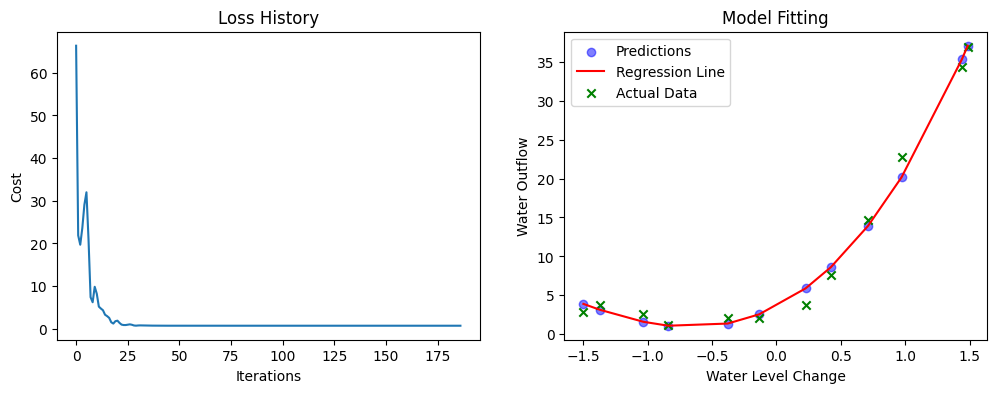

In [50]:
plot_history_predict(std_X,y,history[-1],loss_history)

w: [ 1.12175893e+01  9.70254834e+00  1.78687279e+01  2.24463156e+01
 -2.40167938e+01 -5.18112169e+01 -3.10644297e-02  3.03604478e+01
  2.43339480e+01  1.33876716e+01]
[np.float64(79.14476005753899), np.float64(0.05545148274836225), np.float64(0.04989099318166854), np.float64(0.0466514294230935), np.float64(0.044031955443563135), np.float64(0.041890697024012796), np.float64(0.040127395982721435), np.float64(0.03866347636251439), np.float64(0.03743725317121526), np.float64(0.03640027869100725)]
79.14476005753899 0.0355145627681993


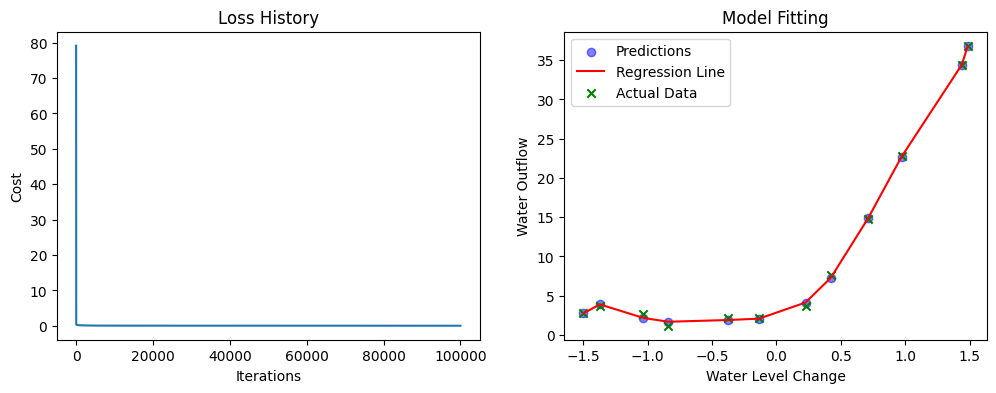

In [51]:
# 1. 初始化特徵：從原始水位數據 x_train 開始
X = x_train
K = 9  # 設定多項式的最高階數為 9

# 2. 特徵擴充 (Feature Expansion)：
# 使用列表推導式生成 x^1, x^2, ..., x^9，並用 np.hstack 水平合併
# 此時 X 的形狀會從 (12, 1) 變成 (12, 9)
X = np.hstack([np.power(X, k+1) for k in range(K)])

# 3. 數據標準化 (Standardization)：
# 由於 x^9 的數值會極大，標準化是確保梯度下降能執行的關鍵步驟
mean = np.mean(X, axis=0)
stddev = np.std(X, axis=0)
X = (X - mean) / stddev  # 將所有特徵縮放到平均值為 0，標準差為 1 的範圍

# 4. 執行訓練：
# 使用你寫的向量化梯度下降函式進行訓練
history = linear_regression_vec(X, y, alpha, iterations)

# 5. 印出最終結果：
print("w:", history[-1]) # 印出 10 個權重 (包含 1 個截距項與 9 個次方的係數)

# 6. 計算損失歷史：
loss_history = compute_loss_history(X, y, history)

# 7. 觀察收斂：印出訓練過程中的 Loss 變化趨勢
print(loss_history[:-1:len(loss_history)//10])
# 印出最初 (High Loss) 與最終 (Lowest Loss) 的數值比較
print(loss_history[0], loss_history[-1])

# 8. 視覺化診斷：
# 同時畫出「損失下降曲線」以及「9 次多項式擬合曲線」
plot_history_predict(X, y, history[-1], loss_history)